# Convergent-Divergent nozzle solver

In this notebook I will plot the Mach number and ratios profiles along the centerline of a convergent-divergent nozzle. I will use the `De_Laval_Solver`.

In order to plot the ratios and Mach number along the length of a nozzle, we need to know:
* the properties of the gas flowing through the nozzle.
* the stagnation condition and the back pressure.
* the geometry of the nozzle. At the moment, two geometries are supported:
    1. `CD_Conical_Nozzle`: a simple conical divergent.
    2. `CD_TOP_Nozzle`: Rao's Thrust Optimized Parabolic contours.
    3. `CD_Min_Length_Nozzle`: Minimum Length Nozzle built with the Method of Characteristics.

Therefore, we need to import the following modules:

In [1]:
from pygasflow.nozzles import CD_TOP_Nozzle, CD_Conical_Nozzle, CD_Min_Length_Nozzle
from pygasflow.utils import Ideal_Gas, Flow_State
from pygasflow.solvers import De_Laval_Solver
import numpy as np

As an example, I'm going to consider air as the gas flowing through, and a stagnation condition at $T_{0}=303.15K$ and $P_{0} = 8 atm$.

In [2]:
# Initialize air as the gas to use in the nozzle
gas = Ideal_Gas(287, 1.4)

# stagnation condition
upstream_state = Flow_State(
    p0 = 8 * 101325,
    t0 = 303.15
)

We need to define the nozzle geometry. The only non-trivial part to understand is that the transition from one region to other should be smooth, therefore:
1. throat region (connecting the convergent with divergent):
    * `CD_TOP_Nozzle` dealt automatically with this region.
    * `CD_Conical_Nozzle`: we need to define a junction radius between the convergent and divergent.
    * `CD_Min_Length_Nozzle`: by assumptio of the Method of Characteristics, the transition is a sharp corner.
2. the region between the "combustion chamber" and convergent. For both `CD_TOP_Nozzle` and `CD_Conical_Nozzle` we need to define a junction radius.

In [3]:
Ri = 0.4
Rt = 0.2
Re = 1.2

# half cone angle of the divergent
theta_c = 40
# half cone angle of the convergent
theta_N = 15

# Junction radius between the convergent and divergent
Rbt = 0.75 * Rt
# Junction radius between the "combustion chamber" and convergent
Rbc = 1.5 * Rt
# Fractional Length of the TOP nozzle with respect to a same exit
# area ratio conical nozzle with 15 deg half-cone angle.
K = 0.8
# geometry type
geom = "axisymmetric"

geom_con = CD_Conical_Nozzle(
    Ri,            # Inlet radius
    Re,            # Exit (outlet) radius
    Rt,            # Throat radius
    Rbt,           # Junction radius ratio at the throat (between the convergent and divergent)
    Rbc,           # Junction radius ratio between the "combustion chamber" and convergent
    theta_c,       # Half angle [degrees] of the convergent.
    theta_N,       # Half angle [degrees] of the conical divergent.
    geom,          # Geometry type
    1000           # Number of discretization points along the total length of the nozzle
)

geom_top = CD_TOP_Nozzle(
    Ri,            # Inlet radius
    Re,            # Exit (outlet) radius
    Rt,            # Throat radius
    Rbc,           # Junction radius ratio between the "combustion chamber" and convergent
    theta_c,       # Half angle [degrees] of the convergent.
    K,             # Fractional Length of the nozzle
    geom,          # Geometry type
    1000           # Number of discretization points along the total length of the nozzle
)

n = 15
gamma = gas.gamma

geom_moc = CD_Min_Length_Nozzle(
    Ri,            # Inlet radius
    Re,            # Exit (outlet) radius
    Rt,            # Throat radius
    Rbt,           # Junction radius ratio at the throat (between the convergent and divergent)
    Rbc,           # Junction radius ratio between the "combustion chamber" and convergent
    theta_c,       # Half angle [degrees] of the convergent.
    n,             # number of characteristics lines
    gamma          # Specific heat ratio
)

If you read through tutorial [07_Nozzles](07_Nozzles.ipynb), you should have spotted an important thing: here we have define the conical and TOP nozzle to have a axisymmetric geometry, but `CD_Min_Length_Nozzle` only works for planar geometry. This means the areas are computed differently. We do expect some difference in the results! 

At this point, I can initialize the solvers. By printing the nozzle, I will see a bunch of interesting data.

In [4]:
# Initialize the nozzle
nozzle_conical = De_Laval_Solver(gas, geom_con, upstream_state)
nozzle_top = De_Laval_Solver(gas, geom_top, upstream_state)
nozzle_moc = De_Laval_Solver(gas, geom_moc, upstream_state)
print(nozzle_conical)

De Laval nozzle characteristics:
Geometry: C-D Conical Nozzle
Radius:
	Ri	0.4
	Re	1.2
	Rt	0.2
Areas:
	Ai	0.5026548245743669
	Ae	4.523893421169302
	At	0.12566370614359174
Lengths:
	Lc	0.40213732393863305
	Ld	3.7517986822069864
	L	4.15393600614562
Angles:
	theta_c	40
	theta_N	15
Critical Quantities:
	T*	252.625
	P*	428225.2171235414
	rho*	5.906279771438798
	u*	318.5980618271241
Important Pressure Ratios:
	r1	0.9998190786765753
	r2	0.03863071458081746
	r3	0.001112598913744237
Flow Condition: 	Undefined
Input state	State 
	M	0
	P	0
	T	0
	rho	0
	P0	810600
	T0	303.15




Note the _Flow Condition: Undefined_. This is expected, because we have not yet given in the back pressure value!

Finally, having chosen the Back to Stagnation pressure ratio, I run the computation on both nozzles and plot the results.

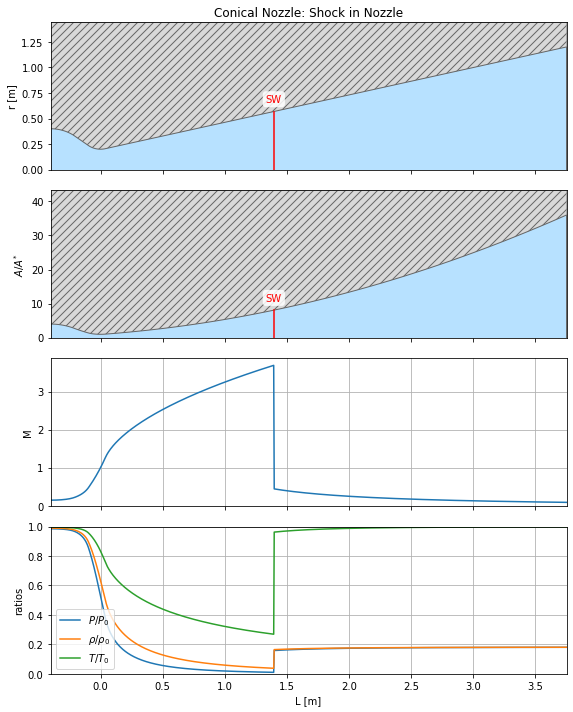

In [5]:
Pb_P0_ratio = 0.18
nozzle_conical.plot(Pb_P0_ratio)

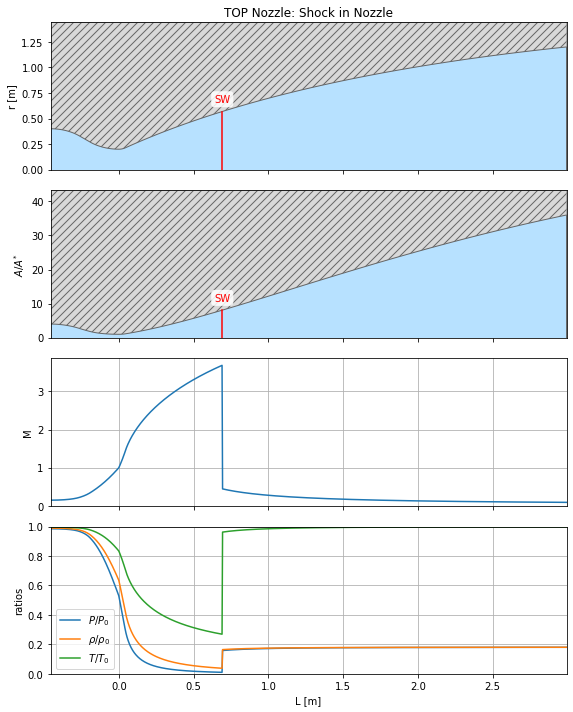

In [6]:
nozzle_top.plot(Pb_P0_ratio)

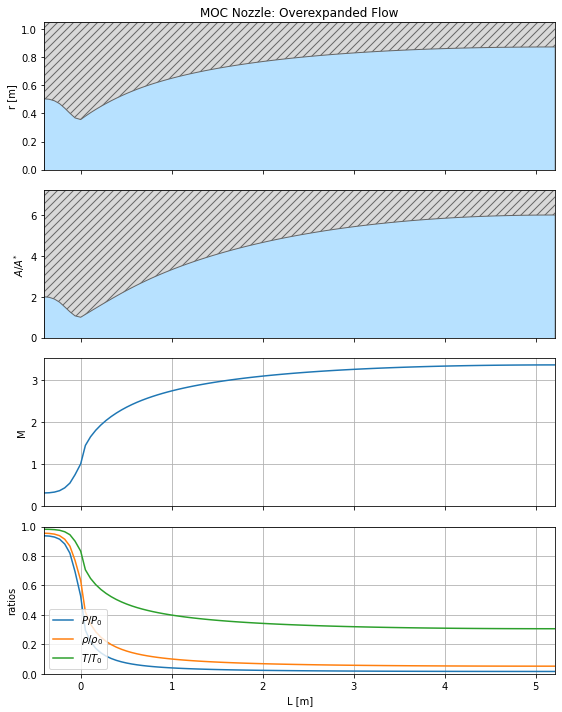

In [7]:
nozzle_moc.plot(Pb_P0_ratio)

What happened here? Why isn't there a shock wave?  
Since `CD_Min_Length_Nozzle` builds a planar geometry, the area is computed differently than `CD_TOP_Nozzle` and `CD_Conical_Nozzle` in the axisymmetric case. In the latters, the well know equation $A = \pi r^{2}$ is used, whereas in the former $A = 2 r$ (please, read the nozzles documentation to understand why). This leads to different area ratios, hence different Mach numbers, as we can see from the plots.

We can also get an hint of it by printing the nozzle:

In [8]:
print(nozzle_moc)

De Laval nozzle characteristics:
Geometry: C-D Minimum Length Nozzle
Radius:
	Ri	0.4
	Re	1.2
	Rt	0.2
Areas:
	Ai	0.8
	Ae	2.4
	At	0.4
Lengths:
	Lc	0.40213732393863305
	Ld	5.2142871958858965
	L	5.6164245198245295
Angles:
	theta_c	40
	theta__w_max	28.186513137228662
Critical Quantities:
	T*	252.625
	P*	428225.2171235414
	rho*	5.906279771438798
	u*	318.5980618271241
Important Pressure Ratios:
	r1	0.9934420158287394
	r2	0.20697969674750344
	r3	0.01584069664398795
Flow Condition: 	Overexpanded Flow
Input state	State 
	M	0
	P	0
	T	0
	rho	0
	P0	810600
	T0	303.15


